In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import hyperspy.api as hs
import numpy as np
import matplotlib.pylab as plt
from emtools import tomo

## Data import
- Read in previously saved reconstruction from the thickest POF overlayer sample
- Extract a single X-Z slice for processing

In [24]:
haadf = hs.load('EncapsulatedPdCatalysts_Sample1_115kX_SIRT_50.hdf5')
haadf.data = 255*haadf.data/haadf.data.max()
haadf.change_dtype('uint8')
haadf = haadf.isig[:,38:427].inav[172:721]

<IPython.core.display.Javascript object>


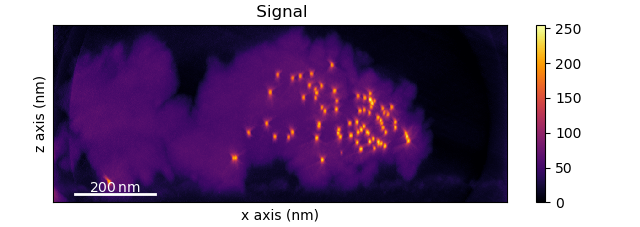

In [166]:
haadf.max().plot(cmap='inferno')

## Template Matching
- Pixels surrouncing a single Pd particle are extracted to use as the template
- Template matching algorithgm in OpenCV used to locate particles
 - Template is correlated with each XY pixel location in the image
 - Results in a 2D correlation map
- Correlation map is then thresholded to find the pixel locations with best match to the template

In [3]:
template = haadf.inav[208:227].isig[570:595,205:230].deepcopy()
result, points = tomo.template_match(haadf, template, 0.45)

<IPython.core.display.Javascript object>


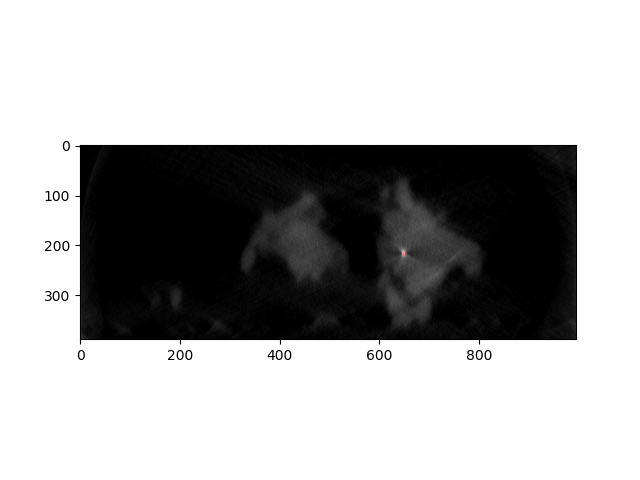

In [125]:
tomo.plot_points(haadf, points, 286)

## Defining the POF Surface
- Convert image to 'uint8' type
- Blur the image using a Gaussian function
- Threshold the image using Otsu's method
- Perform edge detection to fine the outermost surface of the POF

In [178]:
from skimage.filters import gaussian, threshold_otsu, sobel
from skimage.feature import canny

image = haadf.deepcopy()
image.data = gaussian(image.data, sigma=[3,3,3])

threshold = threshold_otsu(image.data)
image.data[image.data<threshold] = 0
image.data[image.data>=threshold] = 255
for i in range(0, image.data.shape[0]):
    image.data [i,:,:] = sobel(image.data[i,:,:])

## Calculate Distance of Particles to Surface
- Calulate distance of each point on the surface curve to the centroids of each particle
- Determine the location on the surface of the minimum calculated difference
- Plot each particle along with the shortest line segment to the surface from calculation

<IPython.core.display.Javascript object>


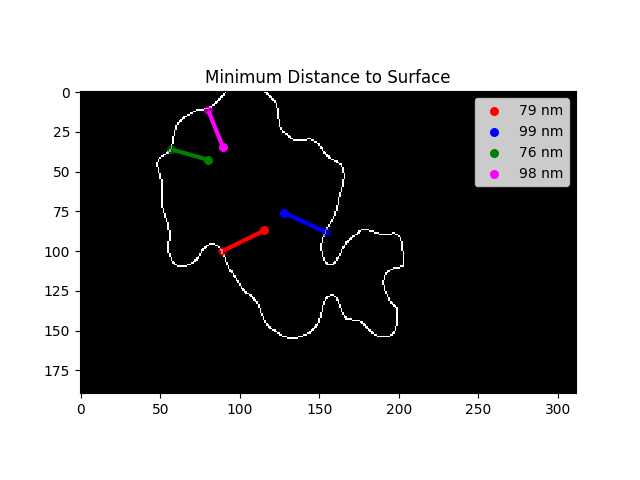

In [497]:
mindistance = np.zeros(points.shape[0])
minloc = np.zeros([points.shape[0],2])
surfacepoints = np.array(np.where(edges==255)).T
for i in range(0,points.shape[0]):    
    distance = np.sqrt(((surfacepoints - points[i][::-1])**2).sum(1))
    mindistance[i] = distance.min()
    minindex = np.argmin(distance)
    minloc[i,:] = surfacepoints[minindex,:]

colors = ['red','blue','green','magenta']
fig,ax = plt.subplots(1)
ax.imshow(edges)
for i in range(0,points.shape[0]):
    ax.scatter(minloc[i,1],minloc[i,0],s=30,color=colors[i],alpha=0.5)
    ax.scatter(points[i,0],points[i,1],s=30,color=colors[i],label=('%s nm' % np.int32((2.3*distance[i]))))
    ax.annotate('', xy=minloc[i,:][::-1], xytext=points[i,:],
                arrowprops=dict(arrowstyle='-',edgecolor=colors[i],facecolor=colors[i],linewidth=3))
    ax.legend()
_ = ax.set_title('Minimum Distance to Surface')